<a href="https://colab.research.google.com/github/K1EH/Software-Maestro/blob/main/Pinecone_Data_Upsert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Library**

In [ ]:
# Vector Embedding
!pip install -q kobert-transformers

# Pinecone
!pip install -q pinecone
!pip install -q pinecone-plugin-inference
!pip install -q pinecone-plugin-interface
!pip install -q pinecone-client
!pip install -q protoc-gen-openapiv2

## **Google Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **Custom Functions**

In [ ]:
def df_left_align(df, num_rows=5):
    """
    스타일을 적용하여 데이터프레임을 좌측 정렬합니다.

    Parameters:
    df (pd.DataFrame): 스타일을 적용할 데이터프레임
    num_rows (int): 출력할 행의 수, 기본값은 5

    Returns:
    pd.io.formats.style.Styler: 좌측 정렬 스타일이 적용된 데이터프레임
    """
    styled_df = df.head(num_rows).style.set_properties(**{'text-align': 'left'})
    styled_df = styled_df.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    return styled_df

# **Data Preprocessing for Upsert VectorDB**

## **Data Preprocessing**

**Load Data**

In [ ]:
dataset_path = "/content/drive/MyDrive/datasets/V2_QuestionsListforVectorDB.csv"

In [ ]:
import pandas as pd

# 엑셀 파일을 읽어옵니다.
df = pd.read_csv(dataset_path, encoding = "utf-8")

df

**Data Preprocessing**

In [ ]:
df_subset = df[['질문', '기술 분야', '기술 키워드']].dropna()
df_subset

In [ ]:
# 특정 컬럼을 리스트로 변환합니다.
questions = df_subset['질문'].tolist()
tech_fields = df_subset['기술 분야'].apply(lambda x: x.split(', ')).tolist()
tech_keywords = df_subset['기술 키워드'].apply(lambda x: x.split(', ')).tolist()

print(tech_fields)

**Create uuid**

In [ ]:
import uuid
uuid_list = []
for _ in range(len(questions)):
  uuid_list.append(str(uuid.uuid4()))
print(f"{uuid_list[0:5]}\n{len(uuid_list)}")

**Vector Embedding**

In [ ]:
from kobert_transformers import get_kobert_model, get_tokenizer
import torch

# KoBERT 모델 및 토크나이저 로드
model = get_kobert_model()
tokenizer = get_tokenizer()

In [ ]:
# 문장을 KoBERT 모델의 입력에 맞게 토큰화
inputs = tokenizer(questions, return_tensors='pt', padding=True, truncation=True)

# KoBERT로 문장 임베딩 생성 (CLS 토큰의 출력을 사용)
with torch.no_grad():
    outputs = model(**inputs)
    sentence_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS 토큰 사용

# 벡터 형태로 변환
embeddings = sentence_embeddings.numpy()

print(embeddings)

**Save Preprocessed Datasets as JSON**

파일 저장 후 꼭 다운로드, Colab 세션 종료 시 데이터 소실됨

In [ ]:
import json

# 딕셔너리 형태로 데이터 결합
data = {
    "uuid_list": uuid_list,
    "questions": questions,
    "embeddings":embeddings.tolist(),
    "tech_fields": tech_fields,
    "tech_keywords": tech_keywords
}

# JSON 파일로 저장
output_path = '/content/drive/MyDrive/datasets/V2_PreprocessedDataset.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

In [ ]:
with open('/content/drive/MyDrive/datasets/V2_PreprocessedDataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [ ]:
# 특정 컬럼 데이터 조회
json_uuid_list = data['uuid_list']
json_questions = data['questions']
json_embeddings = data['embeddings']
json_tech_fields = data['tech_fields']
json_tech_keywords = data['tech_keywords']

df_loaded = pd.DataFrame(data)

# 변환된 DataFrame 출력
df_loaded

**Check Tech Keywords**

In [ ]:
json_tech_keywords

In [ ]:
from collections import Counter

# 개수 카운팅 및 중복 없이 리스트 반환
# 플랫 리스트 생성 및 카운팅
flat_list = [item for sublist in json_tech_keywords for item in sublist]
keyword_counts = Counter(flat_list)
unique_keywords = list(keyword_counts.keys())

print("Keyword Counts:", keyword_counts)
print("Unique Keywords:", unique_keywords)
tech_keywords_df = pd.DataFrame(list(keyword_counts.items()), columns=['Keyword', 'Count'])
tech_keywords_df

# **API KEYS / Environment Variable Setting**

In [ ]:
PINECONE_API_KEY = "INPUT_API_KEY"

## **Pinecone Setting**

In [ ]:
from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec

pc = Pinecone(api_key = PINECONE_API_KEY)

**Version에 따른 index_name 관리**

In [ ]:
index_name = "v2-tech-questions"

In [ ]:
# index_name이 존재하지 않는 경우, 새 index 생성
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=768, # KoBERT의 벡터 차원은 768
        metric="cosine",
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1'
        )
    )
else:
  index = pc.Index(index_name)

[Pinecone-생성된 index 확인](https://app.pinecone.io/organizations/-O5gSVhLYwEb_91KPO77/projects/86f3ee9d-62ba-4885-8503-348118c90769/indexes)

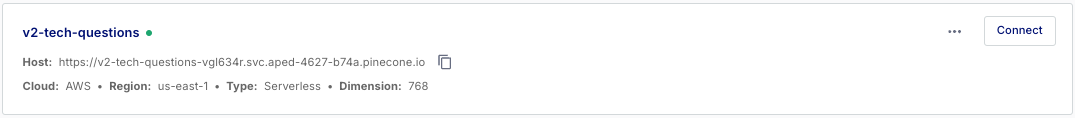

# **Upsert Data to Vector DB**

**Vectors to Upsert Vector DB**

In [ ]:
vectors_for_be_namespace = []
vectors_for_fe_namespace = []
for uuid, question, embedding, tech_field, tech_keyword in zip(json_uuid_list, json_questions, json_embeddings, json_tech_fields, json_tech_keywords):
  ### ['ID', 'Value', 'Metadata'] ###
  if "BE" in tech_field:
    vectors_for_be_namespace.append((uuid, embedding, {"text" : question, "tech_keyword" : tech_keyword}))
  if "FE" in tech_field:
    vectors_for_fe_namespace.append((uuid, embedding, {"text" : question, "tech_keyword" : tech_keyword}))

In [ ]:
print(len(vectors_for_be_namespace))
print(len(vectors_for_fe_namespace))

In [ ]:
index.upsert(
    vectors=vectors_for_be_namespace,
    namespace="BE")

In [ ]:
index.upsert(
    vectors=vectors_for_fe_namespace,
    namespace="FE")

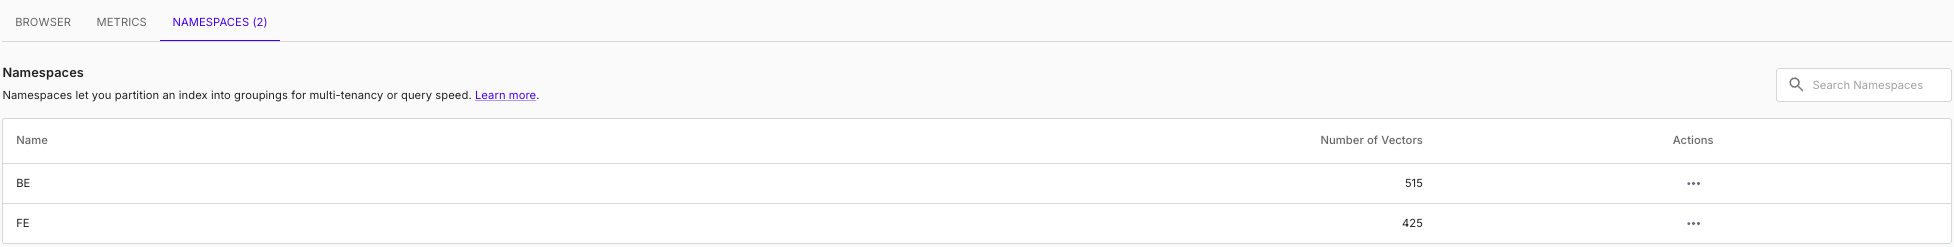